In [30]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense, Dropout
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
import seaborn as sns

In [31]:
#Read the csv file
df = pd.read_csv('/content/drive/MyDrive/Dataset/TSLA .csv')
print(df.head()) #7 columns, including the Date. 

         Date       Open       High        Low      Close  Adj Close    Volume
0  2017-04-03  57.380001  59.799999  56.916000  59.703999  59.703999  69443000
1  2017-04-04  59.377998  60.962002  58.905998  60.740002  60.740002  50673000
2  2017-04-05  60.408001  60.976002  58.840000  59.000000  59.000000  39404500
3  2017-04-06  59.375999  60.388000  58.820000  59.740002  59.740002  27603000
4  2017-04-07  59.500000  60.537998  59.430000  60.507999  60.507999  22898000


In [32]:
len(df)

1261

In [33]:
#Separate dates for future plotting
train_dates = pd.to_datetime(df['Date'])
print(train_dates.tail(15)) #Check last few dates. 


1246   2022-03-15
1247   2022-03-16
1248   2022-03-17
1249   2022-03-18
1250   2022-03-21
1251   2022-03-22
1252   2022-03-23
1253   2022-03-24
1254   2022-03-25
1255   2022-03-28
1256   2022-03-29
1257   2022-03-30
1258   2022-03-31
1259   2022-04-01
1260   2022-04-01
Name: Date, dtype: datetime64[ns]


In [34]:
#Variables for training
cols = list(df)[1:6]
#Date and volume columns are not used in training. 
print(cols) #['Open', 'High', 'Low', 'Close', 'Adj Close']

['Open', 'High', 'Low', 'Close', 'Adj Close']


In [35]:
#New dataframe with only training data - 5 columns
df_for_training = df[cols].astype(float)

In [36]:
#LSTM uses sigmoid and tanh that are sensitive to magnitude so values need to be normalized
# normalize the dataset
scaler = StandardScaler()
scaler = scaler.fit(df_for_training)
df_for_training_scaled = scaler.transform(df_for_training)

In [37]:
#As required for LSTM networks, we require to reshape an input data into n_samples x timesteps x n_features. 
#In this example, the n_features is 5. We will make timesteps = 14 (past days data used for training). 

#Empty lists to be populated using formatted training data
trainX = []
trainY = []

n_future = 1   # Number of days we want to look into the future based on the past days.
n_past = 14  # Number of past days we want to use to predict the future.

#Reformat input data into a shape: (n_samples x timesteps x n_features)
#In my example, my df_for_training_scaled has a shape (1247, 5)
#1247 refers to the number of data points and 5 refers to the columns (multi-variables).
for i in range(n_past, len(df_for_training_scaled) - n_future +1):
    trainX.append(df_for_training_scaled[i - n_past:i, 0:df_for_training.shape[1]])
    trainY.append(df_for_training_scaled[i + n_future - 1:i + n_future, 0])

trainX, trainY = np.array(trainX), np.array(trainY)

print('trainX shape == {}.'.format(trainX.shape))
print('trainY shape == {}.'.format(trainY.shape))

trainX shape == (1247, 14, 5).
trainY shape == (1247, 1).


In [38]:
# define the model 

model = Sequential()
model.add(LSTM(48, activation='relu', input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=True))
model.add(LSTM(48, activation='relu', return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(trainY.shape[1]))

model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 14, 48)            10368     
                                                                 
 lstm_3 (LSTM)               (None, 48)                18624     
                                                                 
 dropout_1 (Dropout)         (None, 48)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 49        
                                                                 
Total params: 29,041
Trainable params: 29,041
Non-trainable params: 0
_________________________________________________________________


Epoch 1/30
71/71 [==============================] - 4s 21ms/step - loss: 0.1405 - val_loss: 0.7457
Epoch 2/30
71/71 [==============================] - 1s 15ms/step - loss: 0.0239 - val_loss: 0.1580
Epoch 3/30
71/71 [==============================] - 1s 15ms/step - loss: 0.0207 - val_loss: 0.0842
Epoch 4/30
71/71 [==============================] - 1s 15ms/step - loss: 0.0203 - val_loss: 0.0580
Epoch 5/30
71/71 [==============================] - 1s 15ms/step - loss: 0.0215 - val_loss: 0.0863
Epoch 6/30
71/71 [==============================] - 1s 15ms/step - loss: 0.0195 - val_loss: 0.2233
Epoch 7/30
71/71 [==============================] - 1s 16ms/step - loss: 0.0199 - val_loss: 0.2942
Epoch 8/30
71/71 [==============================] - 1s 15ms/step - loss: 0.0184 - val_loss: 0.1231
Epoch 9/30
71/71 [==============================] - 1s 15ms/step - loss: 0.0186 - val_loss: 0.2305
Epoch 10/30
71/71 [==============================] - 1s 15ms/step - loss: 0.0180 - val_loss: 0.0319
Epoch 11/

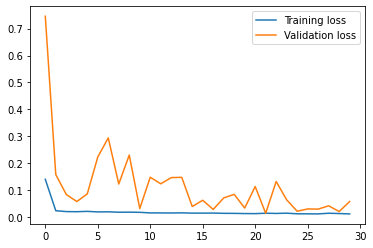

In [39]:
# fit the model
history = model.fit(trainX, trainY, epochs=30, batch_size=16, validation_split=0.1, verbose=1)

plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()

#Predicting...
#Libraries that will help us extract only business days in the US.
#Otherwise our dates would be wrong when we look back (or forward).  
from pandas.tseries.holiday import USFederalHolidayCalendar
from pandas.tseries.offsets import CustomBusinessDay
us_bd = CustomBusinessDay(calendar=USFederalHolidayCalendar())
#Remember that we can only predict one day in future as our model needs 5 variables
#as inputs for prediction. We only have all 5 variables until the last day in our dataset.

In [40]:
n_past = 16
n_days_for_prediction=15  #let us predict past 15 days

predict_period_dates = pd.date_range(list(train_dates)[-n_past], periods=n_days_for_prediction, freq=us_bd).tolist()
print(predict_period_dates)

#Make prediction
prediction = model.predict(trainX[-n_days_for_prediction:]) #shape = (n, 1) where n is the n_days_for_prediction

#Perform inverse transformation to rescale back to original range
#Since we used 5 variables for transform, the inverse expects same dimensions
#Therefore, let us copy our values 5 times and discard them after inverse transform
prediction_copies = np.repeat(prediction, df_for_training.shape[1], axis=-1)
y_pred_future = scaler.inverse_transform(prediction_copies)[:,0]


[Timestamp('2022-03-14 00:00:00', freq='C'), Timestamp('2022-03-15 00:00:00', freq='C'), Timestamp('2022-03-16 00:00:00', freq='C'), Timestamp('2022-03-17 00:00:00', freq='C'), Timestamp('2022-03-18 00:00:00', freq='C'), Timestamp('2022-03-21 00:00:00', freq='C'), Timestamp('2022-03-22 00:00:00', freq='C'), Timestamp('2022-03-23 00:00:00', freq='C'), Timestamp('2022-03-24 00:00:00', freq='C'), Timestamp('2022-03-25 00:00:00', freq='C'), Timestamp('2022-03-28 00:00:00', freq='C'), Timestamp('2022-03-29 00:00:00', freq='C'), Timestamp('2022-03-30 00:00:00', freq='C'), Timestamp('2022-03-31 00:00:00', freq='C'), Timestamp('2022-04-01 00:00:00', freq='C')]


Plotting Original Vs Forecatsed 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will resu

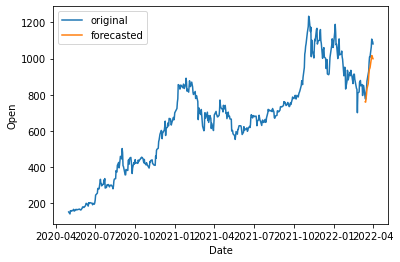

In [49]:
# Convert timestamp to date
forecast_dates = []
for time_i in predict_period_dates:
    forecast_dates.append(time_i.date())
    
df_forecast = pd.DataFrame({'Date':np.array(forecast_dates), 'Open':y_pred_future})
df_forecast['Date']=pd.to_datetime(df_forecast['Date'])


original = df[['Date', 'Open']]
original['Date']=pd.to_datetime(original['Date'])
original = original.loc[original['Date'] >= '2020-5-1']

sns.lineplot(original['Date'], original['Open'],label="original")
sns.lineplot(df_forecast['Date'], df_forecast['Open'],label="forecasted")

